In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loader

In [2]:
import torch.utils.data 

from PIL import Image
import os
import os.path
import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from sklearn import preprocessing
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat


Train data

In [3]:
image_ids = []
xs = []
ys = []
zs = []
c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences"):
  if len(f) > 0:
    c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
  if(c == 500):
    break

    
import pandas as pd

df = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df.head()


,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821


In [4]:
df

,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821
...,...,...,...,...
31689,7179_093.png,-0.098315,0.103608,0.989747
31690,7179_094.png,-0.099317,0.103158,0.989694
31691,7179_095.png,-0.098966,0.103126,0.989733
31692,7179_096.png,-0.098988,0.103495,0.989692


Val Data

In [5]:
image_ids = []
xs = []
ys = []
zs = []
c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences"):
  if len(f) > 0:
    c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
    a = len(image_ids)
    while(a > len(xs)):
      image_ids.pop()
      a -= 1
  if(c == 500):
    break

import pandas as pd

df1 = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df1.head()

,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281


In [6]:
df1

,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281
...,...,...,...,...
15791,8456_045.png,-0.221007,0.232858,0.947066
15792,8456_046.png,-0.220257,0.233302,0.947131
15793,8456_047.png,-0.220212,0.234194,0.946921
15794,8456_049.png,-0.219757,0.234441,0.946966


Test Data

In [7]:
image_ids = []

c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/test/sequences"):
  if len(f) > 0:
    c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)

  if (c == 500):
    break

import pandas as pd

df2 = pd.DataFrame({"unique_id":image_ids})
df2.head()

,unique_id
0,5401_000.png
1,5401_001.png
2,5401_002.png
3,5401_003.png
4,5401_004.png


In [8]:
df2

,unique_id
0,5401_000.png
1,5401_001.png
2,5401_002.png
3,5401_003.png
4,5401_004.png
...,...
12819,5899_038.png
12820,5899_043.png
12821,5899_044.png
12822,5899_048.png


Data Loader and Transforms

In [9]:
class EyeGazeData(Dataset):
    def __init__(self,data_df,data_dir = './',transform=None,train=True,size = 227):
        super().__init__()
        self.data_df = data_df
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          uid,x,y,z = self.data_df.iloc[item]
        else:
          uid = self.data_df.iloc[item]['unique_id']
        #uid,x,y,z = self.data_df.iloc[item]
        seq_id,filename = uid.split('_')
        img_path = os.path.join(self.data_dir+'/'+seq_id,filename)
        
        img = PIL.Image.open(img_path).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.transform, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        label_x = torch.tensor(x, dtype=torch.float32)
        label_y = torch.tensor(y, dtype=torch.float32)
        label_z = torch.tensor(z, dtype=torch.float32)
        
        return img.data, (label_x, label_y, label_z)
    
    def show(self,idx):
        x,y = self.__getitem__(idx)
        label_x, label_y, label_z = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(label_x.item(), label_y.item(), label_z.item()))
    
        

In [10]:
datatransform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(256), 
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_transform = get_transforms(do_flip=False,flip_vert=False,max_zoom=1.05,max_warp=0)

train_dataset = EyeGazeData(df, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences',data_transform[0])
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)

val_dataset = EyeGazeData(df1, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences',data_transform[1])
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2, shuffle=True)

test_dataset = EyeGazeData(df2, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/test/sequences',datatransform,train=False)
test_loader = DataLoader(val_dataset, batch_size=64, num_workers=2, shuffle=True)

data = DataBunch(train_loader, val_loader)

In [11]:
print(data_transform[0])
print(data_transform[1])
print(datatransform)

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)]
[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]
Compose(
    ToPILImage()
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
 

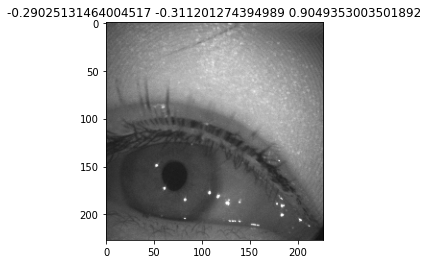

In [12]:
train_dataset.show(200)

ResNet Regression Model

In [13]:
class Resnet_regression(nn.Module):

    def __init__(self, arch,ps=0.5):
        super(Resnet_regression,self).__init__()
        self.encoder = create_body(arch)        #fastai function that creates an encoder given an architecture
        self.fc1 = create_head(1024,1,ps=ps)    #fastai function that creates a head
        self.fc2 = create_head(1024,1,ps=ps)
        self.fc3 = create_head(1024,1,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        label_x = self.fc1(x)
        label_y = self.fc2(x)
        label_z = self.fc3(x)

        return [label_x, label_y, label_z]

Loss Function

In [14]:
class LossWrapper(nn.Module):
    def __init__(self, task_num):
        super(LossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, label_x, label_y, label_z):

        mse = MSELossFlat()

        loss0 = mse(preds[0], label_x)
        loss1 = mse(preds[1], label_y)
        loss2 = mse(preds[2], label_z)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

Activation Function

In [15]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [16]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

Defining Metrics, Learner and Training

In [17]:
def rmse_x(preds, label_x, label_y, label_z): return root_mean_squared_error(preds[0], label_x)
def rmse_y(preds, label_x, label_y, label_z): return root_mean_squared_error(preds[0], label_y)
def rmse_z(preds, label_x, label_y, label_z): return root_mean_squared_error(preds[0], label_z)
metrics = [rmse_x, rmse_y, rmse_z]

In [18]:
model = Resnet_regression(models.resnet34, ps=0.5)

loss_func = LossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

learn.model = convert_act_cls(learn.model, nn.ReLU, Mish())

#splitting the model so that I can use discriminative learning rates
#learn.split([learn.model.encoder[:6], learn.model.encoder[6:], nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
#learn.freeze()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [19]:
torch.cuda.get_device_name()
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

In [20]:
print(model)

Resnet_regression(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): Mish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Learning rate finder

epoch,train_loss,valid_loss,rmse_x,rmse_y,rmse_z,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.29E-03


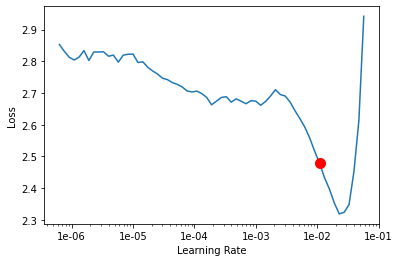

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion = True)


epoch,train_loss,valid_loss,rmse_x,rmse_y,rmse_z,time
0,1.736473,0.951967,0.811817,0.835338,1.414475,1:58:01
1,0.145744,0.038336,0.127786,0.216005,0.913931,1:34:07
2,0.037245,0.022959,0.086783,0.232315,0.968518,1:28:38


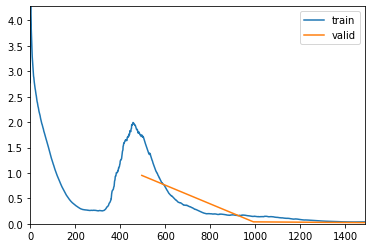

Better model found at epoch 0 with valid_loss value: 0.9519665241241455.
Better model found at epoch 1 with valid_loss value: 0.03833604231476784.
Better model found at epoch 2 with valid_loss value: 0.022958777844905853.


In [22]:
learn.fit_one_cycle(3,max_lr=1e-2, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')])

In [23]:
learn = learn.load("stage-1")


In [24]:
learn.summary

<bound method model_summary of Learner(data=DataBunch;

Train: <__main__.EyeGazeData object at 0x7f5cb3ace470>;

Valid: <__main__.EyeGazeData object at 0x7f5cb3ace6a0>;

Test: None, model=Resnet_regression(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): Mish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1)

Using model to inference

In [25]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_resnet")

In [26]:
class EyeGazePredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms(do_flip=False,flip_vert=False,max_zoom=1.05,max_warp=0)[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 227)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        label_x = torch.exp(preds[0]).item()
        label_y = torch.exp(preds[1]).item()
        label_z = torch.exp(preds[2]).item()
        return label_x, label_y, label_z

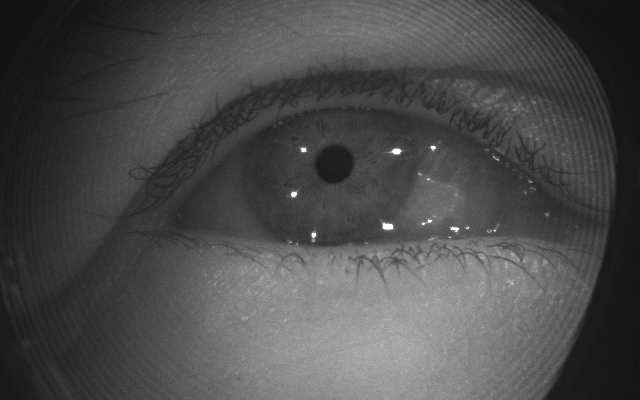

In [27]:
idx = 150
data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
seq_id,filename = df1.unique_id.iloc[idx].split('_')
img_path = os.path.join(data_dir+'/'+seq_id,filename)
img = PIL.Image.open(img_path).convert('RGB')
img 



In [28]:
eyegaze_predictor = EyeGazePredictor(trained_model)

In [29]:
print(eyegaze_predictor.predict(img))

(0.8736538887023926, 1.1646374464035034, 2.6257197856903076)


In [30]:
df1.iloc[idx]

unique_id    7964_039.png
x               -0.205281
y               0.0498439
z                0.977433
Name: 150, dtype: object

**Angular Accuracy**

µ is the pixel size of the particular monitor which is calculated depending on the monitor screen dimensions and pixel resolution. The calculation for the factor µ is shown as: µ = dm/dp where dp is the screen diagonal size in pixels and dm is the diagonal size in mm (converted from inches).


For experiments performed on a 22 inch (diagonal) monitor operating at 680 × 1080 pixel resolution, we had dp = 1981, dm = 558.8 and µ = 0.28.

In [31]:
GazeX = eyegaze_predictor.predict(img)[0]
GazeY = eyegaze_predictor.predict(img)[1]
Z = eyegaze_predictor.predict(img)[2]
GT_x = df1.iloc[idx].x
GT_y = df1.iloc[idx].y
xpixels = 0
ypixels = 0
offset = 0
mu = 0.28

In [32]:
OSD = mu * math.sqrt(pow((GazeX - xpixels/2),2) + pow((ypixels - GazeY + offset),2))
gazeangle = math.atan(OSD/Z)
EGP = math.sqrt(pow(GazeX, 2) + pow(GazeY, 2) + pow(Z, 2))
pix_dist = math.sqrt(pow((GT_x - GazeX), 2) + pow((GT_y - GazeY), 2))
angacc = (mu * pix_dist * (pow(math.cos(gazeangle), 2)))/EGP
print(OSD, EGP)
print(angacc)

0.4076526431984843 3.002341734675725
0.14127975629122627


In [33]:
data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
eyegaze_predictor = EyeGazePredictor(trained_model)
avg_angacc = 0
for idx in range(len(df1)):
  seq_id,filename = df1.unique_id.iloc[idx].split('_')
  img_path = os.path.join(data_dir+'/'+seq_id,filename)
  img = PIL.Image.open(img_path).convert('RGB')
  #print(eyegaze_predictor.predict(img))
  GazeX = eyegaze_predictor.predict(img)[0]
  GazeY = eyegaze_predictor.predict(img)[1]
  Z = eyegaze_predictor.predict(img)[2]
  GT_x = df1.iloc[idx].x
  GT_y = df1.iloc[idx].y
  OSD = mu * math.sqrt(pow((GazeX - xpixels/2),2) + pow((ypixels - GazeY + offset),2))
  gazeangle = math.atan(OSD/Z)
  EGP = math.sqrt(pow(GazeX, 2) + pow(GazeY, 2) + pow(Z, 2))
  pix_dist = math.sqrt(pow((GT_x - GazeX), 2) + pow((GT_y - GazeY), 2))
  angacc = (mu * pix_dist * pow(math.cos(gazeangle), 2))/EGP
  #print("Angular accuracy = ", angacc)
  avg_angacc += angacc

print("Average angular accuracy = ", avg_angacc/len(df1))

Average angular accuracy =  0.13183265623999374


In [34]:
print(math.degrees(avg_angacc/len(df1)))

7.5534548045506575
